런타임 > 런타임 유형 변경 > 하드웨어 가속기 > GPU

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# 데이터 생성

In [0]:
# 시계열 데이터 생성하는 함수
# Sine 함수들의 합성함수 인데, random 성을 넣어 랜덤하게 생성된 시계열 
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [0]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [34]:
# X: 50 by 1 짜리 시계열이 7000개
# y: 1 짜리 output이 7000개

X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

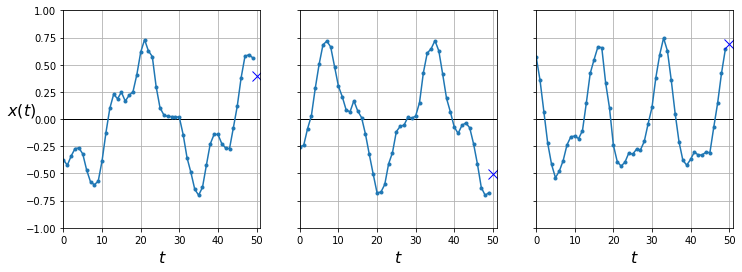

In [35]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))

# 시계열 샘플 3가지를 플라팅
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

# 한 스텝 다음 예측

## 단순 linear regression

In [49]:
np.random.seed(42)
tf.random.set_seed(42)

model_LR = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model_LR.compile(loss="mse", optimizer="adam")
history = model_LR.fit(X_train, y_train, epochs=3,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/3
7000/7000 [==============================] - 1s 108us/sample - loss: 0.1004 - val_loss: 0.0559
Epoch 2/3
7000/7000 [==============================] - 1s 79us/sample - loss: 0.0386 - val_loss: 0.0269
Epoch 3/3
7000/7000 [==============================] - 1s 80us/sample - loss: 0.0205 - val_loss: 0.0162


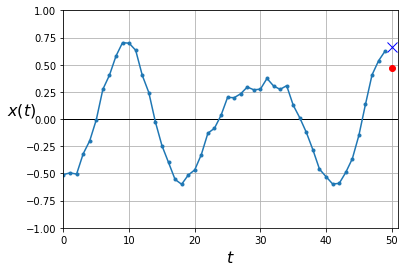

In [56]:
y_pred = model_LR.predict(X_test)
plot_series(X_test[1, :, 0], y_test[1, 0], y_pred[1, 0])
plt.show()

## simple RNN

In [51]:
np.random.seed(42)
tf.random.set_seed(42)

# input_shape=[None, 1] --> recurrent neural network can process any number of time steps
model_simple_RNN = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model_simple_RNN.compile(loss="mse", optimizer=optimizer)
history = model_simple_RNN.fit(X_train, y_train, epochs=3,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/3
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0972 - val_loss: 0.0491
Epoch 2/3
7000/7000 [==============================] - 6s 883us/sample - loss: 0.0372 - val_loss: 0.0298
Epoch 3/3
7000/7000 [==============================] - 6s 906us/sample - loss: 0.0255 - val_loss: 0.0220


In [0]:
y_pred = model_simple_RNN.predict(X_test)
plot_series(X_test[1, :, 0], y_test[1, 0])
plt.show()

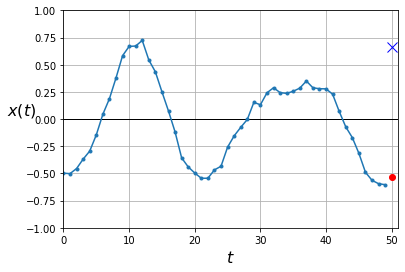

In [106]:
y_pred = model_simple_RNN.predict(X_test)
plot_series(X_test[1, :, 0], y_test[1, 0], y_pred[1, 0])
plt.show()

## Deep RNNs

In [58]:
np.random.seed(42)
tf.random.set_seed(42)

# return_sequences=True --> recurrent layers의 모든 sequence의 output을 출력
# return_sequences=False (default) --> recurrent layers의 마지막 output만 출력 (마지막 simpleRNN)
model_deep_RNN = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.Dense(1)
])

model_deep_RNN.compile(loss="mse", optimizer="adam")
history = model_deep_RNN.fit(X_train, y_train, epochs=3,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/3
7000/7000 [==============================] - 21s 3ms/sample - loss: 0.0433 - val_loss: 0.0073
Epoch 2/3
7000/7000 [==============================] - 19s 3ms/sample - loss: 0.0066 - val_loss: 0.0052
Epoch 3/3
7000/7000 [==============================] - 20s 3ms/sample - loss: 0.0051 - val_loss: 0.0043


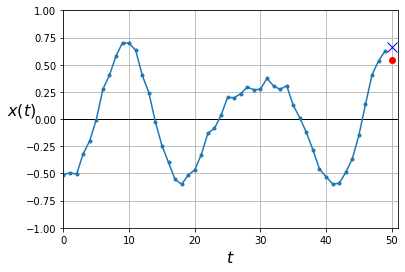

In [59]:
y_pred = model_deep_RNN.predict(X_test)
plot_series(X_test[1, :, 0], y_test[1, 0], y_pred[1, 0])
plt.show()

# 여러 스텝 다음을 예측

### 데이터 생성

In [0]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

In [0]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [110]:
X_train.shape

(7000, 50, 1)

In [111]:
# 다음 10 스텝
Y_train.shape

(7000, 10)

### 단순 linear

In [67]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10) # 출력이 10 스텝
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=5,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/5
7000/7000 [==============================] - 1s 113us/sample - loss: 0.1348 - val_loss: 0.0610
Epoch 2/5
7000/7000 [==============================] - 1s 85us/sample - loss: 0.0501 - val_loss: 0.0427
Epoch 3/5
7000/7000 [==============================] - 1s 85us/sample - loss: 0.0388 - val_loss: 0.0356
Epoch 4/5
7000/7000 [==============================] - 1s 81us/sample - loss: 0.0334 - val_loss: 0.0314
Epoch 5/5
7000/7000 [==============================] - 1s 84us/sample - loss: 0.0299 - val_loss: 0.0286


In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

In [96]:
X_new.shape

(1, 50, 1)

In [97]:
Y_new.shape

(1, 10, 1)

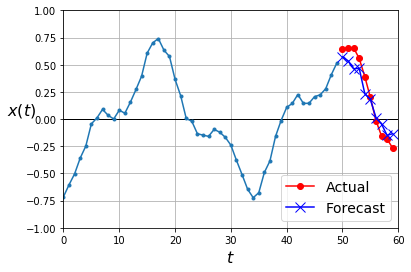

In [95]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Deep RNN

In [101]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=5,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/5
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0665 - val_loss: 0.0317
Epoch 2/5
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0268 - val_loss: 0.0221
Epoch 3/5
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0188 - val_loss: 0.0166
Epoch 4/5
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0159 - val_loss: 0.0137
Epoch 5/5
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0138 - val_loss: 0.0127


In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

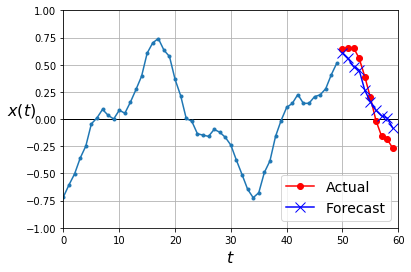

In [104]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# LSTM

In [113]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=5,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/5
7000/7000 [==============================] - 4s 585us/sample - loss: 0.0638 - val_loss: 0.0404
Epoch 2/5
7000/7000 [==============================] - 2s 249us/sample - loss: 0.0320 - val_loss: 0.0253
Epoch 3/5
7000/7000 [==============================] - 2s 247us/sample - loss: 0.0232 - val_loss: 0.0209
Epoch 4/5
7000/7000 [==============================] - 2s 247us/sample - loss: 0.0202 - val_loss: 0.0204
Epoch 5/5
7000/7000 [==============================] - 2s 249us/sample - loss: 0.0182 - val_loss: 0.0178


In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

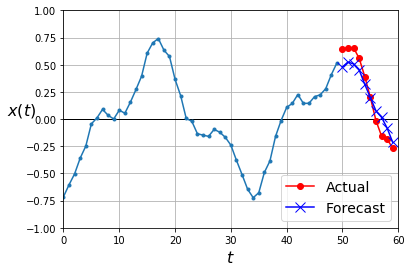

In [117]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRU

In [118]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=5,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/5
7000/7000 [==============================] - 4s 531us/sample - loss: 0.0692 - val_loss: 0.0423
Epoch 2/5
7000/7000 [==============================] - 2s 238us/sample - loss: 0.0385 - val_loss: 0.0359
Epoch 3/5
7000/7000 [==============================] - 2s 247us/sample - loss: 0.0330 - val_loss: 0.0303
Epoch 4/5
7000/7000 [==============================] - 2s 234us/sample - loss: 0.0293 - val_loss: 0.0284
Epoch 5/5
7000/7000 [==============================] - 2s 232us/sample - loss: 0.0253 - val_loss: 0.0215


In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

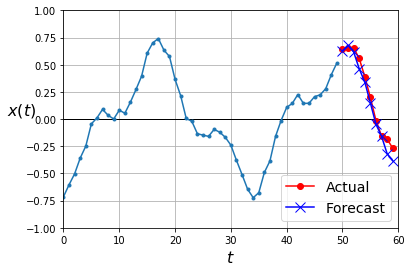

In [120]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()